In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable

from models.mtcnn import PNet, RNet, ONet
from utils.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from utils.first_stage import run_pnet
from utils.second_stage import run_rnet
from utils.third_stage import run_onet
#from utils.first_stage_org import run_first_stage
from utils.visualization_utils import show_bboxes

# Load models

In [2]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

# Set hyperparameters

In [3]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 40.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

# Load an image

1.0


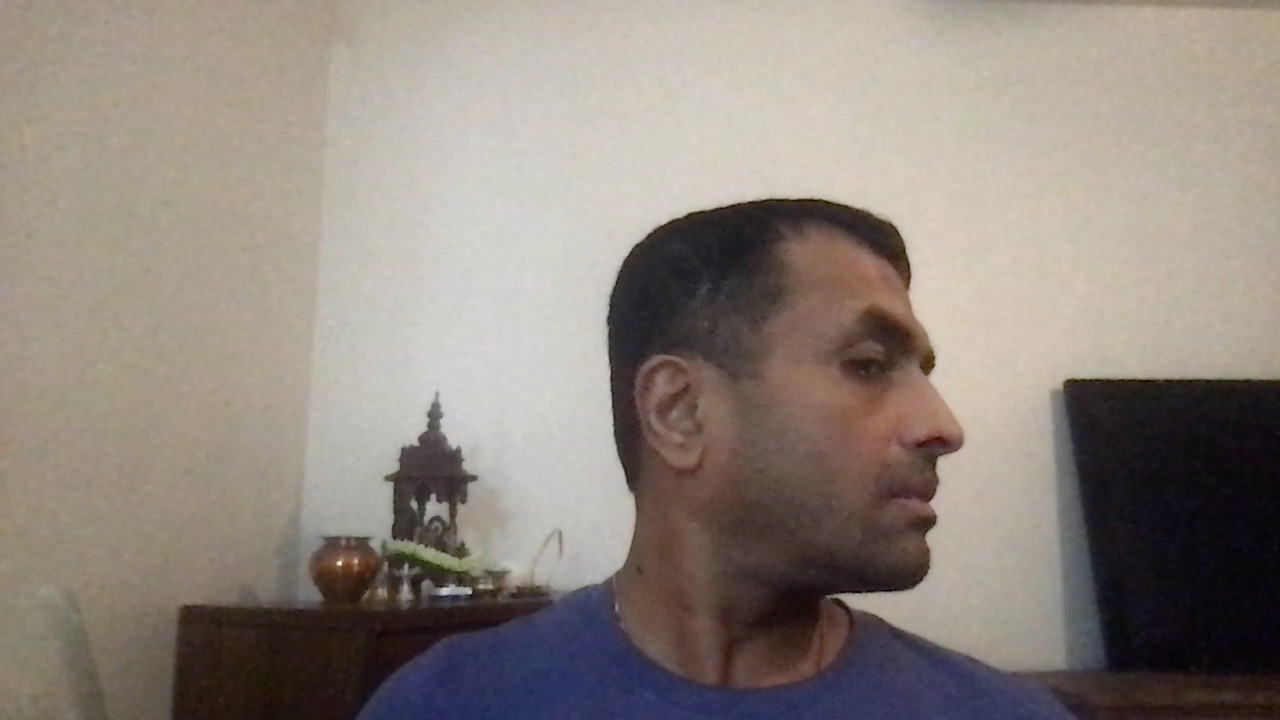

In [4]:
image = Image.open('office5.jpg')
#image = Image.open('./data/test_anchors/n000078/0023_01.jpg')
image = Image.open('./0008_01.jpg')
#image = image.resize((250,200))
img_w, img_h = image.size
scale = min(720. / img_h, 1280. / img_w)
print(scale)
if scale < 1.0:
    image = image.resize((int(1280*scale),int(720*scale)))
image

In [7]:
from utils.box_utils import nms, _preprocess
from utils.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square

def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.

    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.

    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T


def run_pnet1(image, net, threshold, min_face_size=40):
    """Run P-Net, generate bounding boxes, and do NMS.

    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.

    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    width, height = image.size
    min_length = min(height, width)
    
    
    min_detection_size = 12
    image_h_offsets = [[0], [0], [0]]
    factor = 0.707  # sqrt(0.5)

# scales for scaling the image
    scales = [[0.30, 0.026], [0.212, 0.053, 0.037, 0.019], [0.15, 0.106, 0.075]]

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
    m = min_detection_size/min_face_size
    min_length *= m

    for i in range(len(scales)):
        for j in range(len(scales[i])):
            image_h_offsets[i].append(int(scales[i][j]*height))
    

    print('scales:'.format(scales))
    print('image pyramid offsets:', image_h_offsets)
 
    im_data = np.zeros((3, sum(image_h_offsets[2]), int(width*m), 3), dtype=np.float32)
    for i in range(im_data.shape[0]):
        for j, scale in enumerate(scales[i]):
            h_offset = sum(image_h_offsets[i][0:j+1])
            h = int(height * scale)
            w = int(width * scale)
            print(i, h_offset, h, h+h_offset)
            img = image.resize((w, h), Image.BILINEAR)
            img = np.asarray(img, 'float32')
            im_data[i, h_offset:(h_offset+h), :w,:] = img
            
    
    img = torch.tensor(_preprocess1(im_data))
    print(img.shape)
  
    output = pnet(img)        
    probs = output.data.numpy()[:,5,:,:]
    offsets =output.data.numpy()[:,0:4,:,:]
    print(probs.shape)
    print(offsets.shape)    

    bounding_boxes = []
    for i in range(probs.shape[0]):
        bounding_boxes.append([])
      
        for j, scale in enumerate(scales[i]):
            h_offset = sum(image_h_offsets[i][0:j+1])//2
            h = (int(height * scale) - 12) // 2 + 1
            w = (int(width * scale) - 12) // 2 + 1
            boxes = _generate_bboxes(probs[i, h_offset:h_offset+h,:w], offsets[i,:,h_offset:h_offset+h,:w], scale, threshold)
            
            if len(boxes) == 0:
                continue

            keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
            bounding_boxes[i].append(boxes[keep])
    
    bounding_boxes = [[i for i in bounding_boxes[j] if i is not None] for j in range(probs.shape[0])]
    
    for j in range(probs.shape[0]):
        b_boxes = np.vstack(bounding_boxes[j])
        keep = nms(b_boxes[:, 0:5], 0.7)
        b_boxes = b_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
        b_boxes = calibrate_box(b_boxes[:, 0:5], b_boxes[:, 5:])
    # shape [n_boxes, 5]

        b_boxes = convert_to_square(b_boxes)
        b_boxes[:, 0:4] = np.round(b_boxes[:, 0:4])
        print('number of bounding boxes:', len(b_boxes))
        bounding_boxes[j] = b_boxes
    

    return bounding_boxes


# P-Net

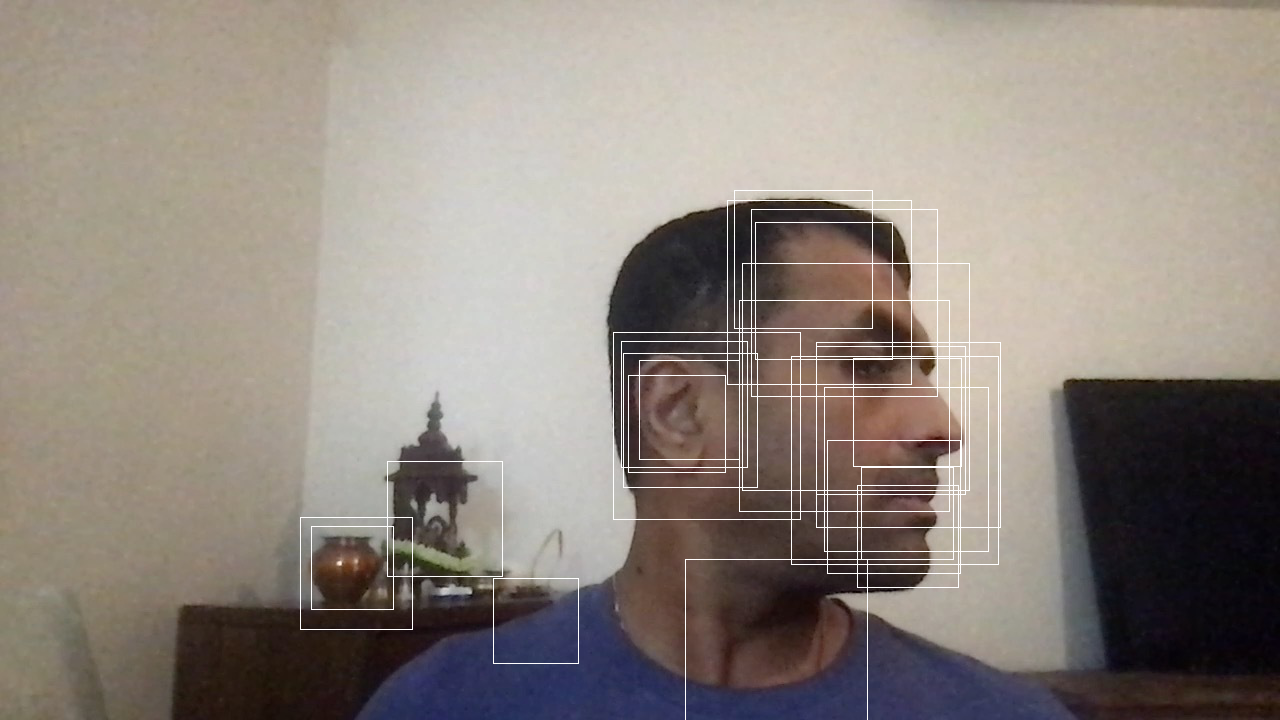

In [12]:

#bounding_boxes = run_pnet1(image, pnet, threshold=thresholds[0], min_face_size=20) #[]
show_bboxes(image, bounding_boxes[2])

In [ ]:
img_boxes = get_image_boxes(bounding_boxes, image, size=24)
bounding_boxes = run_rnet(rnet, img_boxes, thresholds, bounding_boxes)
show_bboxes(image, bounding_boxes)

In [ ]:
img_boxes = get_image_boxes(bounding_boxes, image, size=48)
bounding_boxes, landmarks = run_onet(onet, img_boxes, thresholds, bounding_boxes)
show_bboxes(image, bounding_boxes, landmarks)

In [ ]:
width, height = image.size
min_length = min(height, width)
min_detection_size = 12
min_face_size = 40
factor = 0.707 # sqrt(0.5)
image_h_offsets = [0]
# scales for scaling the image
scales = []

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
        scale = m*factor**factor_count
        image_h_offsets.append(int(scale*height))
        scales.append(scale)
        factor_count += 1
        min_length *= factor

print('scales:', ['{:.3f}'.format(s) for s in scales])
print('image pyramid offsets:', image_h_offsets)
 
im_data = np.zeros((sum(image_h_offsets), int(width*m), 3), dtype=np.float32)
for i, scale in enumerate(scales):
            h_offset = sum(image_h_offsets[0:i+1])
          
            h = int(height * scale)
            print(h_offset, h, h+h_offset)
            w = int(width * scale)
            img = image.resize((w, h), Image.BILINEAR)
            img = np.asarray(img, 'float32')
            im_data[h_offset:(h_offset+h), :w,:] = img

In [ ]:
scales = [[0.30, 0.026], [0.212, 0.053, 0.037, 0.019], [0.15, 0.106, 0.075]]

# R-Net

In [ ]:
width, height = image.size
min_length = min(height, width)
    
    
min_detection_size = 12
image_h_offsets = [[0], [0], [0]]
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
#scales = [[0.30, 0.02], [0.21, 0.05, 0.04], [0.15, 0.10, 0.07]]
#scales = [[0.30, 0.025], [0.21, 0.05, 0.035, 0.017], [0.147, 0.103, 0.072]]

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

for i in range(len(scales)):
    for j in range(len(scales[i])):
        image_h_offsets[i].append(int(scales[i][j]*height))
        
print(image_h_offsets)        

In [ ]:
im_data = np.zeros((3, sum(image_h_offsets[2]), int(width*m), 3), dtype=np.float32)
for i in range(im_data.shape[0]):
    for j, scale in enumerate(scales[i]):
            h_offset = sum(image_h_offsets[i][0:j+1])
            h = int(height * scale)
            w = int(width * scale)
            print(i, h_offset, h, h+h_offset)
            img = image.resize((w, h), Image.BILINEAR)
            img = np.asarray(img, 'float32')
            im_data[i, h_offset:(h_offset+h), :w,:] = img

In [9]:
def _preprocess1(img):
    """Preprocessing step before feeding the network.

    Arguments:
        img: a float numpy array of shape [h, w, c].

    Returns:
        a float numpy array of shape [1, c, h, w].
    """
    img = img.transpose((0, 3, 1, 2))
    #img = np.expand_dims(img, 0)
    img = (img - 127.5)*0.0078125
    #img = np.vstack((img,img))
    return img

In [ ]:
img = torch.tensor(_preprocess1(im_data))
print(img.shape)
threshold = 0.7    
output = pnet(img)        
    #print(output.shape)
    #probs = output[1].data.numpy()[0, 1, :, :]
    #offsets = output[0].data.numpy()
probs = output.data.numpy()[:,5,:,:]
offsets =output.data.numpy()[:,0:4,:,:]
print(probs.shape)
print(offsets.shape)    

bounding_boxes = []
for i in range(probs.shape[0]):
        bounding_boxes.append([])

for i in range(probs.shape[0]):        
    for j, scale in enumerate(scales[i]):
        h_offset = sum(image_h_offsets[i][0:j+1])//2
        h = (int(height * scale) - 12) // 2 + 1
        w = (int(width * scale) - 12) // 2 + 1
        boxes = _generate_bboxes(probs[i, h_offset:h_offset+h,:w], offsets[i,:,h_offset:h_offset+h,:w], scale, threshold)
            
        if len(boxes) == 0:
                continue

        keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
        bounding_boxes[i].append(boxes[keep])
    
bounding_boxes = [[i for i in bounding_boxes[j] if i is not None] for j in range(probs.shape[0])]
    
for j in range(probs.shape[0]):
        b_boxes = np.vstack(bounding_boxes[j])
    #print('number of bounding boxes:', len(bounding_boxes))
    
        keep = nms(b_boxes[:, 0:5], 0.7)
        b_boxes = b_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
        b_boxes = calibrate_box(b_boxes[:, 0:5], b_boxes[:, 5:])
    # shape [n_boxes, 5]

        b_boxes = convert_to_square(b_boxes)
        b_boxes[:, 0:4] = np.round(b_boxes[:, 0:4])
        print('number of bounding boxes:', len(b_boxes))
        bounding_boxes[j] = b_boxes
    


In [ ]:
show_bboxes(image, bounding_boxes[2])